In [73]:
import numpy as np
import importlib
import calibration
importlib.reload(calibration)
import tensorflow as tf
from tensorflow import keras
from keras import layers
import sklearn
import sklearn.metrics
tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()


In [229]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_test = x_test[..., np.newaxis] / 255
x_train = x_train[..., np.newaxis] / 255
y_test = y_test[..., np.newaxis]
y_train = y_train[..., np.newaxis]

def group_in_two(y):
    y[y < 5] = 0
    y[y >= 5] = 1

group_in_two(y_train)
group_in_two(y_test)

rng = np.random.default_rng()
# rng.shuffle(x_train)
# rng.shuffle(x_test)


In [430]:
input_shape = x_train.shape[1:3]
model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Flatten(),
    layers.Dense(1, activation=keras.activations.softplus),
    layers.Dense(4, activation=keras.activations.sigmoid),
    layers.Dense(4, activation=keras.activations.sigmoid),
    layers.Dense(4, activation=keras.activations.sigmoid),
    layers.Dense(4, activation=keras.activations.sigmoid),
    # layers.Dense(4, activation=keras.activations.softplus),
    layers.Dense(1),
    layers.Activation("sigmoid")
    ]
)

def loss_func_entropy(y_true, y_pred):
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    y_true = y_true[:, 0]
    eps = 1e-6
    p0 = tf.clip_by_value(1 - y_pred[:,0] + eps, 0, 1)
    p1 = tf.clip_by_value(y_pred[:,0] + eps, 0, 1)
    loss = -tf.math.xlogy(y_true, p1) - tf.math.xlogy(1 - y_true, p0)
    loss /= tf.math.log(2.0)
    return loss

loss_func = keras.losses.mse
loss_func = loss_func_entropy
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss=loss_func, optimizer=optimizer)
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_27 (Flatten)        (None, 784)               0         
                                                                 
 dense_111 (Dense)           (None, 1)                 785       
                                                                 
 dense_112 (Dense)           (None, 4)                 8         
                                                                 
 dense_113 (Dense)           (None, 4)                 20        
                                                                 
 dense_114 (Dense)           (None, 4)                 20        
                                                                 
 dense_115 (Dense)           (None, 4)                 20        
                                                                 
 dense_116 (Dense)           (None, 1)               

In [449]:
model.optimizer.learning_rate = 0.004
model.fit(x_train, y_train, batch_size=60000, epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 92ms/step - loss: 0.4349
Epoch 2/100
1/1 [==============================] - 0s 21ms/step - loss: 0.4349
Epoch 3/100
1/1 [==============================] - 0s 21ms/step - loss: 0.4349
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 0.4349
Epoch 5/100
1/1 [==============================] - 0s 19ms/step - loss: 0.4349
Epoch 6/100
1/1 [==============================] - 0s 21ms/step - loss: 0.4349
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.4349
Epoch 8/100
1/1 [==============================] - 0s 24ms/step - loss: 0.4349
Epoch 9/100
1/1 [==============================] - 0s 28ms/step - loss: 0.4349
Epoch 10/100
1/1 [==============================] - 0s 27ms/step - loss: 0.4349
Epoch 11/100
1/1 [==============================] - 0s 25ms/step - loss: 0.4349
Epoch 12/100
1/1 [==============================] - 0s 26ms/step - loss: 0.4349
Epoch 13/100
1/1 [==============================]

In [450]:
def print_res(x, y_true, name):
    scores = model(x).numpy()
    y_pred = scores >= 0.5
    loss = loss_func(y_true, scores).numpy()
    loss_av = np.average(loss)
    e_loss = loss_func_entropy(y_true, scores)
    e_loss_av = np.average(e_loss)
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    entropy = calibration.get_binary_entropy(y_true)
    print(f"{name}  entropy={entropy:.4} accuracy={accuracy:.4} loss={loss_av:.4} entropy_loss={e_loss_av:.4}")

print_res(x_train, y_train, "train")
print_res(x_test, y_test, "test")


train  entropy=0.9997 accuracy=0.8916 loss=0.4347 entropy_loss=0.4347
test  entropy=0.9994 accuracy=0.8834 loss=0.4505 entropy_loss=0.4505


***** train ******


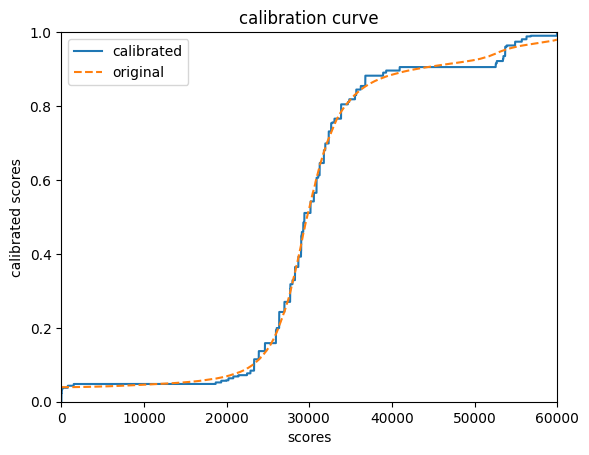

loss=0.4347 loss_calib=0.4312 accuracy=0.8916
***** test ******


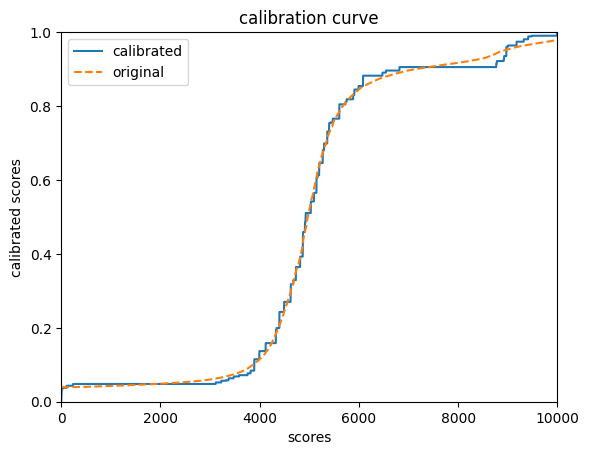

loss=0.4505 loss_calib=0.4485 accuracy=0.8834


In [451]:
scores_train = model(x_train).numpy()
calib_func = calibration.get_calibration_function(y_train.squeeze(1), scores_train.squeeze(1))

def print_calib(x, y_true, name):
    print(f"***** {name} ******")
    scores = model(x).numpy().squeeze(1)
    y_pred = scores >= 0.5
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    calib_scores = np.vectorize(calib_func)(scores).astype(np.float32)
    calibration.plot_calibrated_curve(scores, calib_scores)
    loss = loss_func(y_true, scores[:, None])
    loss_calib = loss_func(y_true, calib_scores[:, None])
    print(f"loss={np.average(loss):.4} loss_calib={np.average(loss_calib):.4} accuracy={accuracy:.4}")

print_calib(x_train, y_train, "train")
print_calib(x_test, y_test, "test")



In [64]:
w = model.weights
w0 = w[0].numpy()
w1 = w[1].numpy()